## Imports

In [1]:
import pyearthtools.data
import tempfile

## Variables

In [2]:
doi = '2021-01-01T0100'
var = '2t'

# DataIndexes
One of the base classes of `edit.data` is the `DataIndex`, which provides a unified interface to accessing data, and common data retrieval techniques.

As of the writing of this notebook, the following data sources have been implemented and don't require any custom indexes:
- ERA5
- ACCESS G/C
- BRAN
- OceanMAPS
- Himiwari 8/9

However, to extend the usability of `edit.data` a user can implement a custom Indexer to provide access to any data source.

If the data exists as a standard netcdf file, it is possible to simply implement the file search functions, and leave data retrieval functions to the parent classes.

## How to Guide

Use `edit.data.DataIndex` for data that a series cannot be retrieved for, and `edit.data.OperatorIndex` for data for which a series can be retrieved.

The general layout requires that all variables be set in the DataIndex initialisation, such that when looking for a file or data, only the timestep of that data need be supplied.

In [3]:
class CustomDataIndex(pyearthtools.data.OperatorIndex):
    def __init__(self, variables, transforms = None):
        variables = [variables] if isinstance(variables, str) else variables
        self.variables = variables # Set variables to be retrieved
        
        ##Initialise Parent Class, passing in base_transforms and data resolution
        ## Setup transform to cut data to specified variable
        base_transforms = pyearthtools.data.transform.variables.variable_trim(variables) + transforms
        
        #Lets say this is hourly data
        super().__init__(base_transforms, (1,'H'))
        
    def filesystem(self, querytime):
        #Ensure querytime is a datetime
        querytime = pyearthtools.data.pyearthtools_datetime(querytime)
        #Lets assume a simple filestructure
        ROOT_PATH = '/data/is/here'
        date_path = querytime.strftime("%Y/%m/%d")
        
        #Return a path for each variable
        paths = {}
        for var in self.variables:
            paths[var] = f"{ROOT_PATH}/{date_path}/{var}.nc"
            
        return paths

Lets now use this with the search function, which allows multiple file path functions to be set depending on the environment.

In [4]:
CustomDataIndex('TestVariable').search(doi)

{'TestVariable': '/data/is/here/2021/01/01/TestVariable.nc'}

If the data retrieval is more complex than this, the `get` function can be overwritten. 

It is expected that the `get` function returns an xarray Dataset with the requested data.

In [5]:
class CustomDataIndexGet(CustomDataIndex):
    def get(querytime):
        #Do special operation to open the data
        ds = ...
        return ds

### Caching Data / Data Not on Disk
If a dataset does not exist on disk in the required format, the `filesystem` function can be left unimplemented, but the `get` function must be. This will allow all indexing functions still to operate, with the data being generated each time.

However, if this generation is a costly operation, it is possible to cache this data out to disk using `edit.data.CachingIndex`, overriding the `generate` function.
This Cacher requires that either a location to save to is set, or a pattern in which to generate save locations is defined.

If only a location is set, the default pattern is `expanded_date`, (more on patterns in `9-PatternIndexing.ipynb`)

In [6]:
class CustomCachingIndex(pyearthtools.data.CachingIndex):
    def __init__(self, variables, cachelocation, transforms = None):
        variables = [variables] if isinstance(variables, str) else variables
        self.variables = variables # Set variables to be retrieved
        
        ##Initialise Parent Class, passing in base_transforms and data resolution
        ## Setup transform to cut data to specified variable
        base_transforms = pyearthtools.data.transform.variables.variable_trim(variables) + transforms
        
        #Lets say this is hourly data
        super().__init__(cache = cachelocation, base_transforms = base_transforms, data_resolution = (1,'H'))
    
    def generate(self, querytime):
        #For simplicity this generate will return ERA5 mutliplied by 2
        ERA5 = pyearthtools.data.archive.ERA5(self.variables,level = 'single')
        return ERA5(querytime, self.base_transforms) * 2
        

Using the CachingIndex...

Path: /jobfs/77764019.gadi-pbs/tmpn6q7ygne/2021/01/01/20210101T0100.nc


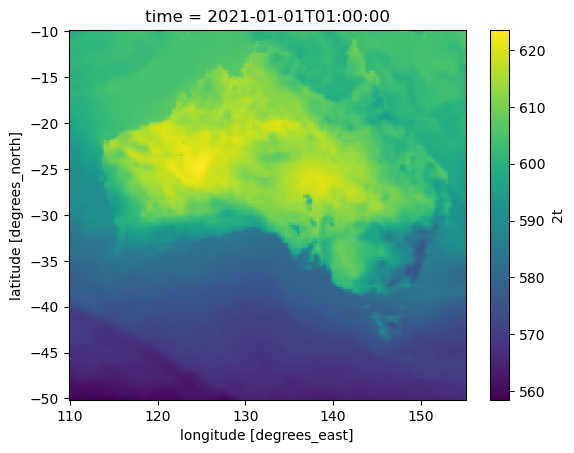

In [7]:
region_subset = pyearthtools.data.transform.region('Australia')

with tempfile.TemporaryDirectory() as tempdir:
    CacheIndex = CustomCachingIndex(var, tempdir, transforms = region_subset)
    
    print('Path:', CacheIndex.search(doi))
    CacheIndex(doi)[var].plot()